# Application 4: Twitter Sentiment Analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets, preprocessing 
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *
from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')

In [2]:
import ipywidgets as widgets
from IPython.display import clear_output

In [3]:
import re # for regular expressions 
import nltk # for text manipulation 
from nltk.stem.porter import * 
from wordcloud import WordCloud 

In [4]:
# pip install wordcloud

In [5]:
tweets = pd.read_csv('data.csv')

In [6]:
tweets[tweets['label'] == 0].head(10) #non racist/sexist tweets

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...
7,8,0,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...


In [7]:
tweets[tweets['label'] == 1].head(10) #racist/sexist tweets

,id,label,tweet
13,14,1,@user #cnn calls #michigan middle school 'buil...
14,15,1,no comment! in #australia #opkillingbay #se...
17,18,1,retweet if you agree!
23,24,1,@user @user lumpy says i am a . prove it lumpy.
34,35,1,it's unbelievable that in the 21st century we'...
56,57,1,@user lets fight against #love #peace
68,69,1,ð©the white establishment can't have blk fol...
77,78,1,"@user hey, white people: you can call people '..."
82,83,1,how the #altright uses &amp; insecurity to lu...
111,112,1,@user i'm not interested in a #linguistics tha...


In [8]:
tweets.shape

(31962, 3)

In [9]:
tweets["label"].value_counts()

0    29720
1     2242
Name: label, dtype: int64

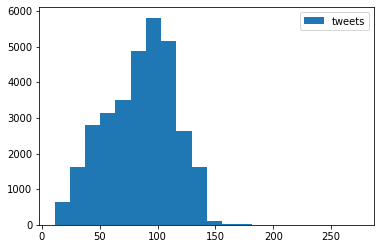

In [10]:
length_tweets = tweets['tweet'].str.len() 
plt.hist(length_tweets, bins=20, label="tweets") 
plt.legend() 
plt.show()

## Data Cleaning

In [11]:
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)
    return input_txt 

**Removing Twitter Handles (@user)**

In [12]:
tweets['tidy_tweet'] = np.vectorize(remove_pattern)(tweets['tweet'],"@[\w]*") 
tweets.head(10)

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can't use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide: society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,[2/2] huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow dannyâ¦
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams.ð...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won!!! love the land!!! #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here ! i'm it's so #gr8 !


**Removing Punctuations, Numbers, and Special Characters**

In [13]:
tweets['tidy_tweet'] = tweets['tidy_tweet'].str.replace('[^a-zA-Z# ]', " ", regex=True) 
tweets.head(10)

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks for #lyft credit i can t use cause th...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation,factsguide society now #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,huge fan fare and big talking before the...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0,the next school year is the year for exams.ð...,the next school year is the year for exams ...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,we won love the land #allin #cavs #champ...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here i m it s so #gr


**Removing Short Words**

In [14]:
tweets['tidy_tweet'] = tweets['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
tweets.head(10)

,id,label,tweet,tidy_tweet
0,1,0,@user when a father is dysfunctional and is s...,when father dysfunctional selfish drags kids i...
1,2,0,@user @user thanks for #lyft credit i can't us...,thanks #lyft credit cause they offer wheelchai...
2,3,0,bihday your majesty,bihday your majesty
3,4,0,#model i love u take with u all the time in ...,#model love take with time
4,5,0,factsguide: society now #motivation,factsguide society #motivation
5,6,0,[2/2] huge fan fare and big talking before the...,huge fare talking before they leave chaos disp...
6,7,0,@user camping tomorrow @user @user @user @use...,camping tomorrow danny
7,8,0,the next school year is the year for exams.ð...,next school year year exams think about that #...
8,9,0,we won!!! love the land!!! #allin #cavs #champ...,love land #allin #cavs #champions #cleveland #...
9,10,0,@user @user welcome here ! i'm it's so #gr...,welcome here


**Text Normalization**

Tokenize --> Normalize (using nltk’s PorterStemmer() function)

Tokens are individual terms or words.

Tokenization is the process of splitting a string of text into tokens.

In [15]:
tokenized_tweet = tweets['tidy_tweet'].apply(lambda x: x.split()) #tokenizing 
tokenized_tweet.head(10)

0    [when, father, dysfunctional, selfish, drags, ...
1    [thanks, #lyft, credit, cause, they, offer, wh...
2                              [bihday, your, majesty]
3                     [#model, love, take, with, time]
4                   [factsguide, society, #motivation]
5    [huge, fare, talking, before, they, leave, cha...
6                           [camping, tomorrow, danny]
7    [next, school, year, year, exams, think, about...
8    [love, land, #allin, #cavs, #champions, #cleve...
9                                      [welcome, here]
Name: tidy_tweet, dtype: object

In [16]:
stemmer = PorterStemmer() 
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_tweet.head(10)

0    [when, father, dysfunct, selfish, drag, kid, i...
1    [thank, #lyft, credit, caus, they, offer, whee...
2                              [bihday, your, majesti]
3                     [#model, love, take, with, time]
4                         [factsguid, societi, #motiv]
5    [huge, fare, talk, befor, they, leav, chao, di...
6                              [camp, tomorrow, danni]
7    [next, school, year, year, exam, think, about,...
8    [love, land, #allin, #cav, #champion, #clevela...
9                                       [welcom, here]
Name: tidy_tweet, dtype: object

Join tokens back using nltk’s MosesDetokenizer function

In [17]:
for i in range(len(tokenized_tweet)):
    detokenized_tweet[i] = ' '.join(tokenized_tweet[i]) 
tweets['tidy_tweet'] = detokenized_tweet
tokenized_tweet.head(10)

NameError: name 'detokenized_tweet' is not defined

**Understanding the common words used in the tweets: WordCloud**

Most frequent words appear in large size and the less
frequent words appear in smaller sizes.

In [ ]:
all_words = ' '.join([text for text in tweets['tidy_tweet']]) 
 
wordcloud = WordCloud(width=800, 
                      height=500,
                      random_state=21, 
                      max_font_size=110).generate(all_words) 

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

We can see most of the words are positive or neutral. Words like love, great, friend, life are the most frequent ones. It doesn’t give us any idea about the words associated with the racist/sexist tweets. Hence, we will plot separate wordclouds for both the classes (racist/sexist or not) in our tweets data.

Words in non racist/sexist tweets


In [ ]:
normal_words =' '.join([text for text in tweets['tidy_tweet'][tweets['label'] == 0]]) 

wordcloud = WordCloud(width=800, 
                      height=500, 
                      random_state=21,
                      max_font_size=110).generate(normal_words) 

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [ ]:
#Racist/Sexist Tweets
negative_words = ' '.join([text for text in tweets['tidy_tweet'][tweets['label'] == 1]])

wordcloud = WordCloud(width=800, 
                      height=500,
                      random_state=21, 
                      max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7)) 
plt.imshow(wordcloud)
plt.axis('off') 
plt.show()

**Understanding the impact of Hashtags on tweets sentiment**

Hashtags in twitter are synonymous with the ongoing trends on twitter at any particular point in time. We should try to check whether these hashtags add any value to our sentiment analysis
task, i.e., they help in distinguishing tweets into the different sentiments.


In [ ]:
# function to collect hashtags 
def hashtag_extract(x): 
    hashtags = [] 
    # Loop over the words in the tweet 
    for i in x: 
        ht = re.findall(r"#(\w+)", i) 
        hashtags.append(ht) 
    return hashtags

In [ ]:
# extracting hashtags from non racist/sexist tweets 
HT_regular = hashtag_extract(tweets['tidy_tweet'][tweets['label'] == 0]) 
print(HT_regular[0:5])

# extracting hashtags from racist/sexist tweets 
HT_negative = hashtag_extract(tweets['tidy_tweet'][tweets['label'] == 1]) 
print(HT_negative[0:5])

In [ ]:
# unnesting list 
HT_regular = sum(HT_regular, []) 
print(HT_regular[0:5])

HT_negative = sum(HT_negative, [])
print(HT_negative[0:5])

In [ ]:
#Non-Racist/Sexist Tweets
frequency_distribution = nltk.FreqDist(HT_regular) 
df = pd.DataFrame({'Hashtag': list(frequency_distribution.keys()), 'Count': list(frequency_distribution.values())}) 

# selecting top 20 most frequent hashtags 
df = df.nlargest(columns="Count", n = 20) 

plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=df, x= "Hashtag", y = "Count") 
ax.set(ylabel = 'Count')
plt.show()

All these hashtags are positive and it makes sense. We expect negative terms in the plot of
the second list.

**Checking the most frequent hashtags appearing in the racist/sexist tweets.**

In [ ]:
#Racist/Sexist Tweets
b = nltk.FreqDist(HT_negative) 
e = pd.DataFrame({'Hashtag': list(b.keys()),'Count': list(b.values())}) 

# selecting top 20 most frequent hashtags 
e = e.nlargest(columns="Count", n = 20) 
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
plt.show()

**TF-IDF**

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df=2, 
                                   max_features=1000, 
                                   stop_words='english') 

tfidf = tfidf_vectorizer.fit_transform(tweets['tidy_tweet'])
vocab = tfidf_vectorizer.vocabulary_
tfidf.shape

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(tfidf, tweets['label'], random_state=42, test_size=0.3)

In [ ]:
data = pd.DataFrame(tfidf)
data.head()

In [ ]:
classifiers = []

lr_classifier = LogisticRegression()#
classifiers.append(lr_classifier)
lda_classifier = LinearDiscriminantAnalysis()
classifiers.append(lda_classifier)
svc_classifier = SVC(probability=True)#
classifiers.append(svc_classifier)
kn_classifier = KNeighborsClassifier()#
classifiers.append(kn_classifier)
gnb_classifier = GaussianNB() #
classifiers.append(gnb_classifier)
dt_classifier = DecisionTreeClassifier(max_depth = 10) #
classifiers.append(dt_classifier)
rf_classifier = RandomForestClassifier()#
classifiers.append(rf_classifier)

### Multinomial Naive Bayes Classifier

In [ ]:
mnb_classifier = MultinomialNB()

In [ ]:
mnb_classifier.fit(X_train, Y_train)
y_pred = mnb_classifier.predict(X_test)

In [ ]:
print(confusion_matrix(Y_test, y_pred))

In [ ]:
print(classification_report(Y_test, y_pred))

### Logistic Regression

In [ ]:
lr_classifier.fit(X_train, Y_train)
prediction = lr_classifier.predict(X_test) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

### LDA

In [ ]:
lda_classifier.fit(X_train.toarray(), Y_train)
prediction = lda_classifier.predict(X_test.toarray()) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

### SVM - Support Vector Machines

In [ ]:
svc_classifier.fit(X_train, Y_train)
prediction = svc_classifier.predict(X_test) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

### k-nearest neighbors Classifier

In [ ]:
kn_classifier.fit(X_train, Y_train)
prediction = kn_classifier.predict(X_test) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

### Decision Tree

In [ ]:
dt_classifier.fit(X_train, Y_train)
prediction = dt_classifier.predict(X_test) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

In [ ]:
fig = plt.figure(figsize=(25,20))
_ = plot_tree(dt_classifier, 
              filled=True)
plt.show()

In [ ]:
fig.savefig("decision_tree.png")

### Random Forest

In [ ]:
rf_classifier.fit(X_train, Y_train)
prediction = rf_classifier.predict(X_test) 
print(metrics.accuracy_score(Y_test, prediction))
print(metrics.precision_score(Y_test, prediction))
print(metrics.recall_score(Y_test, prediction))

fig = plt.figure(figsize=(25,10))
plot_tree(rf_classifier.estimators_[0], 
                  max_depth = 5,
                  rounded = True, 
                  precision = 2,
                  filled = True,
                  )
plt.show()

In [ ]:
fig = plt.figure(figsize=(25,10))
plot_tree(rf_classifier.estimators_[1], 
                  max_depth = 5,
                  rounded = True, 
                  precision = 2,
                  filled = True,
                  )
plt.show()

In [ ]:
data.head()

In [ ]:
tweet = widgets.Text(description="tweet")

In [ ]:
display(tweet)

In [ ]:
algorithm = widgets.Dropdown(
    options = [('Logistic Regression', 'LR'), 
               ('Linear Discriminant Analysis ', 'LDA'), 
               ('Support Vector Machines', 'SVM'),
               ('K-Nearest Neighbors', 'KN'),
               ('Multinomial Naive Bayes', 'MNB'),
               ('Decision Trees', 'DT'),
               ('Random Forest', 'RF'),
              ],
    disabled = False,
)

print('Select Algorithm')
display(algorithm)

In [ ]:
prediction = widgets.Output()

button_predict = widgets.Button(description="Predict")

def on_button_predict_clicked(b):
    
    input_data = {}
    input_data['tweet'] = tweet.value
    
    user_input = pd.DataFrame(input_data, columns = ['tweet'], index=[0])
    #print(user_input)
    user_input['tidy_tweet'] = np.vectorize(remove_pattern)(user_input['tweet'],"@[\w]*") 
    user_input['tidy_tweet'] = user_input['tidy_tweet'].str.replace('[^a-zA-Z# ]', " ", regex=True) 
    user_input['tidy_tweet'] = user_input['tidy_tweet'].apply(lambda x:' '.join([w for w in x.split() if len(w)>3]))
    tokenized_tweet = user_input['tidy_tweet'].apply(lambda x: x.split()) #tokenizing 
    tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
    detokenized_tweet = ' '.join(tokenized_tweet[0]) 
    user_input['tidy_tweet'] = detokenized_tweet
    vectorizer = TfidfVectorizer(max_df=0.90, 
                                   min_df=2, 
                                   max_features=1000, 
                                   stop_words='english', vocabulary=vocab) 
    tf_idf = vectorizer.fit_transform(tweets['tidy_tweet']) 
    
    selected_algorithm = algorithm.value
    
    if selected_algorithm == 'LR':
        classifier = lr_classifier
    elif selected_algorithm == 'LDA':
        classifier = lda_classifier
    elif selected_algorithm == 'SVM':
        classifier = svc_classifier        
    elif selected_algorithm == 'KN':
        classifier = kn_classifier
    elif selected_algorithm == 'MNB':
        classifier = mnb_classifier
    elif selected_algorithm == 'DT':
        classifier = dt_classifier
    elif selected_algorithm == 'RF':
        classifier = rf_classifier
        
    with prediction:
        clear_output(True)
        print(f'Selected Algorithm = {selected_algorithm}')
        print(classifier.predict(tf_idf)[0])
        
button_predict.on_click(on_button_predict_clicked)

In [ ]:
display(button_predict)
display(prediction)